<a id='section0'></a>
# Computational Linguistics: Final Project WS19/20
## Skipgram model with negative sampling in Tensorflow
### by Johannes Bernhard (2544368)

DISCLAIMER: I figured that it would be easiest if I included all code documentation in this notebook and showed some results analysis in my report PDF. Thus, this notebook will cover all aspects of my code and the report will have some interesting insights from the results (plots, embeddings, etc.). The notebook is part 1, the PDF is part 2.<br>

#### Table of Contents:<br>
[0. Introduction](#introduction)<br>
[1. Get poetry data and preprocess it](#section1)<br>
[2. Create training batches](#section2)<br>
[3. Define the Skipgram Model](#section3)<br>
[4. Train the model and save the embeddings](#section4)<br>
[5. Get some basic information on the model (loss, low-dimension visualizations of embeddings)](#section5)<br>
[6. Visualize the entire embedding space in Tensorboard](#section6)<br>
[References](#references)

The final submission includes:
- Jupyter notebook
- Result report 
- Data folder containing the poetry corpus
- Checkpoints folder containing the model weights + loss
- Back-up folder with model weights again, just in case something goes wrong while running the notebook (I just want to make sure that my results are reproducible).<br>

The notebook needs to be in the same folder as the "data" and "checkpoints" folders.

<a id='introduction'></a>
### 0. Introduction (1/2)

[back to top](#section0)

This is my implementation of the Skipgram model with negative sampling using Tensorflow/Keras. The original inception of the word2vec architectures (CBOW, Skipgram) was first presented by Mikolov et al. in their paper "Efficient Estimation of Word Representations in Vector Space" ([1](#references)).<br>

The word2vec model in its basic form is a simple feed-forward network with a single hidden layer and a softmax output layer. The hidden layer has no activation function because we will be using this as the word embedding layer later on and thus want to keep the learned weights unmodified. <br>
Words in a vocabulary are encoded with unique IDs, usually in an ascending order based on their absolute frequency. These IDs are then used during the input to refer the model to that specific row in the hidden layer matrix. As an example, if "the" is encoded as the very first ID, then the very first row in the hidden layer matrix will correspond to the vector representation for "the". Thus, for a given input word, the hidden layer functions as a look-up table. 
The main difference betweeen CBOW and Skipgram is that the latter predicts a context based on a given word, while CBOW predicts a word given a context.<br>
In the case of the Skipgram model, the context words are the labels during training. Input and label pairs are generated by a moving window that traverses a sentence and returns the word at the center of the window with the words in proximity (exactly how many is determined by the window size) as training pairs. When we receive an (input word, context word) pair during training, the softmax output layer generates probabilities for words in the vocabulary that they will be the given context word. The loss is then updated based on the correctness of this prediction. In order to alleviate the computational burden during training, Mikolov et al. make use of negative sampling, where, for each training example, the model only evaluates the loss on a user-defined number of negative samples ([6](#references)). This way, we don't need to update the hidden layer matrix for every single word in the vocabulary. It is enough to update the input word, context word and negative word vectors.<br>
After training, the word embeddings are retrieved from the hidden layer and the softmax layer is ignored. During training, the model will have brought the hidden layer vectors of words whose contexts are similar closer together, meaning that their values will be close to one another and they will be close in the vector space. For the model, this reduced loss since predicting the contexts for closely related words thus becomes easier. For us, this gives us so called word embeddings. If we now evaluate the nearest neighbors of a given word vector, the closest vectors will be those of words with similar contexts and meanings to the given word.<br>
Both CBOW and Skipgram give NLP practitioners an alternative to sparse TF-IDF vectors as well as Latent Dirichlet Allocation (LDA) and Latent Semantic Analysis (LSA) representations by outputting dense, continuous word vectors that preserve linear regularities between words. These word vectors can be efficiently trained on much more data and perform the best when used with neural models for NLP tasks.<br><br>
For this submission, I have taken into account the random window size per batch R, as presented in the Mikolov et al. paper.<br>
The model in this submission is trained on a Gutenberg poetry corpus as provided by Allison Parish ([2](#references)) which consists of ~3 million lines of poetry, extracted from books in the Project Gutenberg library. My choice of this corpus was motivated by the fact that I hope for the skipgram model to show potentially interesting word relationships that might be unique to poetry texts or at the very least more pronounced in these texts.<br>
The code in this project was put together using various Tensorflow tutorial and documentation pages. I have done my best to document where I found the code. In general, much information came from the various subpages of https://www.tensorflow.org/guide, with some additional help from the Keras documentation (https://keras.io/). <br>
Part of the difficulty of this project was familiarizing myself more with the Tensorflow and Keras APIs as I had not worked with them very much during my studies. Additionally, the recent merge from Tensorflow 1 to Tensorflow 2.0 overhauled many concepts which I had become familiar with. <br>
The final implementation follows this pipeline: <br>
[1. Get poetry data and preprocess it](#section1) &#9658; [2. Create training batches](#section2) &#9658; [3. Define the Skipgram Model](#section3) &#9658; [4. Train the model and save the embeddings](#section4) &#9658; [5. Get some basic information on the model (loss, low-dimension visualizations of embeddings)](#section5) &#9658; [6. Visualize the entire embedding space in Tensorboard](#section6) <br>
So without further ado, let's get started.

To execute all code, it is enough to run all cells that contain code one after the other. However, be warned that training the final model took my laptop 5-6 hours using its CPU (I only found out that my Nvidia card is not CUDA compatible after purchasing my laptop, oops). Running this on the CoLi servers might be advisable.  
Either way, the final model files are included in the project submission so it is possible to recreate the results without retraining the model.<br>
The training script is set to save model parameters after every epoch. I have only included the final epoch parameters in order to save space.

The notebook requires the external libraries Tensorflow 2.0 (or higher, I had 2.0 installed), numpy, sklearn and matplotlib.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import numpy as np

from matplotlib import pylab
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.0.0
Num GPUs Available:  0


In [2]:
from timeit import default_timer as timer
from collections import Counter
import re
import os
import random
import pandas
import csv
import gzip, json

<a id='section1'></a>
### 1. Getting poetry data and pre-processing
[(back to top)](#section0)<br>
<br>
As already mentioned, the text data I used consisted of poetry texts from the Project Gutenberg library, joined into a corpus by Allison Parrish. These texts are not all poems. There are many longer texts describing the authors, origins and histories of the poems.  
The text comes in a newline delimited json format with an "s" key giving us the line of poetry text and a "gid" key giving us the document ID for this line.  
In the following scripts, I first load the data and preprocess it according to my specifications. Then the vocabulary is extracted and word-integer and integer-word mappings are created. These mappings are required for the model to learn the embeddings since it cannot work with text data. Finally, all preprocessed words are mapped to their integer values thus giving us our model input data.

Contents of this section:
- preprocess function
- get_vocab function
- word2int function
- int2word function
- Calling above functions to process the poetry corpus.

In [3]:
def preprocess(file, num_lines, n=5):
    """
    Process the text data. Extract all text lines into one string. 
    Num_lines allows us to specify whether we want to use the entire corpus or only a subset.
    n represents the word frequency threshold. Any word with a frequency below n will be dropped from the final text.
    :param file: gzip file containing text data.
    :param num_lines: number of lines in text data to consider (int).
    :param n: absolute word frequency threshold (int).
    :return: list of words
    """
    all_lines = [] #variable to store text data from gzip file.
    with gzip.open(file) as data:
        for line in data:
            all_lines.append(json.loads(line.strip())) #this extracts all "s" and "gid" values.
        #should num_lines be specified to be larger than the actual number of lines in the corpus,
        #this limits it to the actual max. corpus size.
        if num_lines > len(all_lines):
            num_lines = len(all_lines)
            text = " ".join([line["s"] for line in all_lines[:num_lines]])
        else:
            text = " ".join([line["s"] for line in all_lines[:num_lines]])
        words = text.split() #split string into single list entries
        #lowercase all words and only consider alphabetic character entries.
        words = [w.lower() for w in words if w.isalpha()]
        #further filter the words by removing "the" and "a". These are just noise.
        #Looking at it now, should have probably included a couple more stop words. 
        #I refrained from using a stop words list, because I wanted to keep pronouns etc. They might be interesting.
        words = [w for w in words if w != "the" and w != "a"]
        #Get counts of the filtered words and filter the words one last time to include only words more frequent than n.
        word_counts = Counter(words)
        words = [w for w in words if word_counts[w] > n]
        del text #we don't need this variable anymore
    return words

In [4]:
def get_vocab(words):
    """
    Extract unique words from the words list. Sort them by their frequency.
    :param words: words list.
    :return: unique words list.
    """
    #Simply count all words in the filtered words list and sort them based on frequency.
    word_counts = Counter(words)
    vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    return vocab

In [32]:
def word2int(vocab):
    """
    Create a word to integer/ID mapping.
    :param vocab: list of unique words sorted by frequency.
    :return: integer mapped dictionary.
    """
    #We want every word to have a unique integer value (ID).
    #To do this, we simply enumerate the words in the vocab list and create dict entries based on their position.
    #We already sorted the vocab list by frequency, so the ID values will be ascending based on frequency.
    intmap = dict((word, index) for index, word in enumerate(vocab)) #{word#1: 0, word#2: 1, word#3: 2.....}
    return intmap

In [6]:
def int2word(vocab):
    """
    Create a integer/ID to word mapping.
    :param vocab: list of unique words sorted by frequency.
    :return: word mapped dictionary
    """
    #We do the same thing as in the case of word to integer mapping.
    #The only difference is that each key is an ID and the value is the word.
    #Later, this allows us to get the labels for the final embeddings.
    wordmap = dict((index, word) for index, word in enumerate(vocab))
    return wordmap

In [7]:
#Preprocess the poetry texts. The current configuration extracts the entire corpus (~3million lines).
#N is set to 10 in the hope to clear up the final embedding space.
words = preprocess("data/gutenberg-poetry-v001.ndjson.gz", num_lines=4000000, n=10)

15288577


In [8]:
#Get the vocabulary
vocab = get_vocab(words)

#Get each word's unique integer value/ID
word_mapping = word2int(vocab)

#Get the word behind each integer/ID
int_mapping = int2word(vocab)

#Map each word in the processed data to its integer/ID.
mapped_words = [word_mapping[w] for w in words]

<a id='section2'></a>
### 2. Create training batches
[(back to top)](#section0)<br>
<br>
The next step is to create training data in the form of batches.  
The model trains by looking at a "center word" and "context words" in a window around the "center word". So we need data that gives us a center word and all its context words in the form of (center (input), context (label)) or similiar.  
An example with a window size of +/- 2:  
"The brown fox jumps over"; center: "fox", contexts: "the", "brown", "jumps", "over".   
Training examples in the form of (input, label): (fox, the), (fox, brown), (fox, jumps), (fox, over).  
To do this for our data, we write a "create_batches" function that, during its call, uses another function "get_label".  In our case, the final output is of the form ([fox, fox, fox, fox],([the], [brown], [jumps], [over]) (in integer form) which can be fed into the model as training data. The exact process is described in the functions themselves.

Contents of this section:
- create_batches function
- get_label function

In [41]:
def create_batches(words, batch_size, window):
    """
    Create (input, target) pairs from a batch_sized chunk of our mapped words.
    This is a generator function to save memory.
    :param words: list of integer mapped words.
    :param batch_size: size of batches or chunks to partition mapped words into.
    :param window: window size for (input, label) generation.
    :yield: np.arrays of center words and their context labels.
    """
    #We go through our mapped words and partition them into batch sized chunks. Starting from the first word.
    for index in range(0, len(words), batch_size):
        #Initialize empty lists to store the center words (X) and their labels (Y)
        #We use lists here and convert them to numpy arrays later since numpy append/join operations are very inefficient.
        #They create copies of both the list to append to and the list that is being appended. We don't need that.
        X = []
        Y = []
        #Generate the batch for each batch_sized jump in our mapped words index.
        #Its size is that of the batch size.
        batch = words[index:index+batch_size]
        #Iterate through the batch. 
        #The current word is the word at the batch index. Its labels are then generated via the "get_label" function.
        #The batch_index gives the "get_label" function the index with which to determine the window position.
        #Finally, extend the X and Y lists. We use extend here, since this is 1. faster and 
        #2. we want to append the list of labels without creating sublists from the list return in "get_label".
        #Additionally, the X extension is multiplied by the number of labels returned,
        #in order to ensure that for each center word we get the appropriate number of (input,label) pairs.
        #An example output is given with the "fox" input in the text description above.
        for batch_index in range(len(batch)):
            current_word = batch[batch_index]
            current_labels = get_label(batch, batch_index, window)
            X.extend([current_word]*len(current_labels))
            Y.extend(current_labels)
        #The numpy array conversion is necessary since Tensorflow requires numpy inputs.
        yield np.array(X), np.array(Y)[:,None]

In [34]:
def get_label(words, index, window):
    """
    Generate the labels (context) words for a given center word.
    :param words: list of words in our batch.
    :param index: current index in the word list.
    :param window: window size (int)
    :return: list of labels/context words
    """
    #As per the description in the Mikolov et al. paper, 
    #we want the window size to be a random number between 1 and our window value.
    #Quote: "select randomly a number R in range <1;C >", where C is our window size.
    window_size = np.random.randint(1, window+1)
    #Here we define some conditions to make sure our window start fits for the beginning of a batch.
    #If the value from (index-window_size) is larger than 0,
    #we can be sure that the window start will cover words before our current center word.
    #If this is not larger than 0, the window start is the very first index in the batch.
    #An example: input --> (the, fox, jumps, over). The window start (assuming window_size = 1) for "the" will be 0 
    #since (index_the (0) - index_fox (1)) !> 0. The window start for "jump" will be 1, since 2-1 > 0.
    if index - window_size > 0:
        win_start = index - window_size
    else:
        win_start = 0
    #The window end is simply the current index + the current window size.
    win_end = index + window_size
    #We use a set operation here to eliminate any redundant words in constructions such as "and he and his son".
    #Here, the contexts for "he" (with win_size=1) would be (and, and). We don't need "and" two times in this case.
    #We get window_size words before and after the current index.
    labels = set(words[win_start:index] + words[index+1:win_end+1])
    #Want it as a list for final output though. 
    #We need a list return here to ensure the "create_batches" function gets the right amount of center word entries.
    return list(labels)

<a id='section3'></a>
### 3. Defining the Skipgram model
[(back to top)](#section0)<br>
<br>
This code was put together using a variety of Tensorflow sources.
These are: 
- https://www.tensorflow.org/guide/keras/train_and_evaluate#part_ii_writing_your_own_training_evaluation_loops_from_scratch
- https://www.tensorflow.org/guide/keras/custom_layers_and_models#building_models
- https://www.tensorflow.org/guide/keras/save_and_serialize#part_ii_saving_and_loading_of_subclassed_models

My initial thoughts were that it would be possible to write a skipgram model in the Keras API using their simple "model add layer" technique, compiling and fitting, while saving model data such as loss/weights/accuracy etc during training. All with a few lines of code. Keras even has a skipgram function (https://keras.io/preprocessing/sequence/). However, this function was very time-consuming to run and there is no negative sample loss function. Due to these missing components, putting together the out-of-the-box Keras modules with a custom loss and custom training data was the only option.  
It was necessary to write a subclassed model since this allows us to use the Tensorflow API negative sampling loss function "sampled_softmax_loss" (https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss). 
The model itself is very simple and consists of two layers: 
1. An embedding layer of the size (vocab_size, embedding size). 
2. A softmax layer with a weight matrix of size (vocab_size, embedding_size) and a bias vector of size (vocab_size).

We train the model to predict the probability of context words (softmax layer) and extract the embedding layer at the end of training. The negative sampling method allows us to train the model much faster by only looking at a set number of "negative" (wrong) labels for each training sample. These small comparisons are used to adjust only the weights of the current word and the negative sampled words. This significantly reduces the computational complexity of the weight adjustments for a given training example.
As an optimizer I simply used ADAM with no real hyperparameter tuning. That would be something to look at in later editions of this model.

Contents of this section:
- SkipgramModel class

In [3]:
class SkipgramModel(tf.keras.Model):
    """
    The actual (subclassed) Skipgram Model.
    :param vocab_size: size of the vocabulary.
    :param embedding_size: embedding layer size.
    :param negative_samples: number of negative samples to use.
    """
    def __init__(self, vocab_size, embedding_size, negative_samples):
        super(SkipgramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.negative_samples = negative_samples
        #Define the model layers.
        #Embedding is the embedding layer. Its is defined as random values from a uniform distr. in the range <-1;1>.
        #w is the weight matrix of the softmax layer, sampled uniformly from a range <-1;1>.
        #b is the bias vector initialized to 0 with length vocab_size.
        #Together they combine to the characteristic Wx+b fully connected layer computation.
        #Softmax is then used as an activation function on this Wx+b.
        #The ADAM optimizer is then used to update the weights via backpropagation.
        self.embedding = tf.Variable(tf.random.uniform([vocab_size, embedding_size], minval=-1, maxval=1))
        self.w = tf.Variable(tf.random.uniform([vocab_size, embedding_size], minval=-1, maxval=1))
        self.b = tf.Variable(tf.zeros([vocab_size]))
        self.optimizer = tf.keras.optimizers.Adam()
        
    def call(self, inputs):
        """
        Get the embedding layer value for given input IDs.
        The ID of a word is mapped to the corresponding row number in the embedding matrix.
        Example: "schoolboy" gets ID 10900. The 10900th row in the embedding matrix will be the vector representation of "schoolboy".
        :param inputs: word IDs
        :return: embedding tensors for given inputs."""
        current_embedding = tf.nn.embedding_lookup(self.embedding, inputs)
        return current_embedding
        
    def compute_loss(self, inputs, labels):
        """
        Compute the current loss, given the current center and context words and N random negative examples.
        :param inputs: center word embedding tensors.
        :param labels: context word labels
        :return: loss value
        """
        #As mentioned above, this loss function makes use of negative sampling.
        #Num_sampled specifies how many negative examples to consider.
        #The embeddings are fed in as is, since we do not want to use an activation function on the embedding layer.
        loss = tf.nn.sampled_softmax_loss(
                    weights = self.w,
                    biases = self.b,
                    labels = labels,
                    inputs = inputs,
                    num_sampled = self.negative_samples,
                    num_classes = self.vocab_size)
        loss = tf.reduce_mean(loss)
        return loss
    
    def train_step(self, inputs, labels):
        """
        Conduct a single training step.
        Get embeddings --> Compute loss --> Get gradients --> Update weights using optimizer.
        :param inputs: center/target word embedding tensors.
        :param labels: context word labels
        :return: loss value
        """
        #Here, I use GradientTape to record the forward pass computations.
        #These computations are then recorded on the "GradientTape" in order to pass them easily to the optimizer.
        with tf.GradientTape() as tape:
            #First, get the input embeddings.
            #Then compute the loss for the current embeddings and their labels.
            input_embedding = self.call(inputs)
            labels = tf.cast(labels, dtype=tf.int64) #issues with Tensorflow being picky about data types.
            loss = self.compute_loss(input_embedding, labels)
        #Grads returns the gradients for the training step with respect to the loss.
        grads = tape.gradient(loss, model.trainable_weights)
        #Pass the recorded gradients to the optimizer and perform gradient descent on the trainable parameters.
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return loss

<a id='section4'></a>
### 4. Training the model and saving embeddings.
[(back to top)](#section0)<br>
<br>
In the next cells, the Skipgram Model is trained.  
Since this takes quite some time, the cell below the training loop will load the saved embeddings from the provided checkpoint file. That way, it is possible to later visualize the embeddings without having to train the model again.
First, we have to define a couple of hyperparameters. These include:  
- embedding size: this is the column dimension of the embedding matrix. The larger it is, the more information we should be able to capture about the words. However, computational complexity rises as well. It is set to 128 here, as this seems to be a common base size.
- Negatives: Number of negative samples to use when computing the loss. This is the number of non-context words to use in combination with the center word. Set to 64.
- batch_size: The size of the partitions given as training batches. It is set to 1000 words.
- window_size: The maximum value that the window can have. It is set to 10. This means that a maximum of 10 context words will be considered before and after the current center word. The thought behind setting the size to 10 was that the lines in a poem should not be too long and perhaps a length of up to 20 (before+after context words) would be a good way to capture the center word's context in the poem.
- epochs: The number of times to repeat the training steps. It is set to 5. This seemed like a reasonable choice, especially considering the amount of time needed to train the model. The number of training steps is given by (len(words)/batch_size), which in my final trained model amounted to ~15300 steps per epoch (~15.3 million words / 1000). After completion of all training steps, the model repeats the process, advancing one epoch. The random window size <1;10> ensures that the contexts aren't always the same per run, thus giving some training variation.

In order to keep track of the model's progress, we save checkpoint files every now and again.
I saved the model's current loss every 100 steps and also saved the weights every epoch. Finally, the model's learned embeddings are saved in a final epoch file so that they are easily loadable later.<br>This training loop code was inspired by: https://www.tensorflow.org/guide/keras/train_and_evaluate#using_the_gradienttape_a_first_end-to-end_example.

Content of this section:
- Defining hyperparameters and creating model
- Training loop
- Loading of model

In [49]:
#make sure a checkpoint directory exists
!mkdir checkpoints
vocab_size = len(vocab) #number of rows in embedding matrix
embedding_size = 128 #number of columns in embedding matrix
negatives = 64 #number of negative samples
batch_size = 1000 #size of text chunks
epochs = 5
window_size = 10
skipgram_losses = [] #to save model loss
#initialize the Skipgram Model
model = SkipgramModel(vocab_size, embedding_size, negative_samples=negatives)

Ein Unterverzeichnis oder eine Datei mit dem Namen "checkpoints" existiert bereits.


In [16]:
#The actual training loop.
#Execution of this cell can be skipped! All output files are already provided.
print("Starting Training.\n")
total_start = timer()
for i in range(1,epochs+1):
    print("\nTraining Epoch {0}/{1}\n".format(i, epochs))
    #Create training data for the current epoch.
    train_data = create_batches(mapped_words, batch_size, window_size)
    start = timer()
    #Iterate through the batches of inputs/labels and compute the model's loss.
    for step, (batch_x_train, batch_y_train) in enumerate(train_data):
        loss = model.train_step(batch_x_train, batch_y_train)
        
        #Every 100 steps, give a short progress report and add loss to the loss list.
        if step % 100 == 0:
            end = timer()
            current_time = (end-start)/100
            skipgram_losses.append(loss)
            print("Step: {}".format(step),
                "Avg. Training loss: {:.4f}".format(loss),
                "{0} sec/batch".format(round(current_time, 3)), end="  \r")
            start = timer()
            
    #Save model weights every epoch. We don't really need this in our case but it seems to be advised everywhere.
    #It ensures that we can go back and retrain the model with a different set-up for example.
    if i % 1 == 0:
        model.save_weights("checkpoints/gutenberg_epoch_{0}.ckpt".format(i), save_format="tf")

#Save the final weights. This saves all trainable parameters, including optimizer, weight + bias matrices.
#But most importantly, it saves the embedding matrix.
model.save_weights("checkpoints/gutenberg_final_epoch.ckpt", save_format="tf")

#Write model loss to a csv file. We can use this to plot loss later.
#I chose to write this to a file and plot it from the file later.
#This is just in case model training isn't possible during the project evaluation.
#That way, it is still possible to see how my own model run progressed.
with open('checkpoints/skipgram_losses.csv', 'wt', encoding="utf8") as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(skipgram_losses)

total_end = timer()
total_time = total_end - total_start
print("\nTotal time elapsed: {0} seconds".format(round(total_time, 3)))

Ein Unterverzeichnis oder eine Datei mit dem Namen "checkpoints" existiert bereits.


Starting Training.


Training Epoch 1/5

Step: 15200 Avg. Training loss: 4.4465 0.273 sec/batch  
Training Epoch 2/5

Step: 15200 Avg. Training loss: 4.3174 0.274 sec/batch  
Training Epoch 3/5

Step: 15200 Avg. Training loss: 4.2730 0.274 sec/batch  
Training Epoch 4/5

Step: 15200 Avg. Training loss: 4.1934 0.273 sec/batch  
Training Epoch 5/5

Step: 15200 Avg. Training loss: 4.1269 0.272 sec/batch  
Total time elapsed: 20879.301 seconds


Final model training process:
------------------------------------------
Starting Training.


Training Epoch 1/5

Step: 15200 Avg. Training loss: 4.4465 0.273 sec/batch  
Training Epoch 2/5

Step: 15200 Avg. Training loss: 4.3174 0.274 sec/batch  
Training Epoch 3/5

Step: 15200 Avg. Training loss: 4.2730 0.274 sec/batch  
Training Epoch 4/5

Step: 15200 Avg. Training loss: 4.1934 0.273 sec/batch  
Training Epoch 5/5

Step: 15200 Avg. Training loss: 4.1269 0.272 sec/batch  
Total time elapsed: 20879.301 seconds

In [1]:
#Load the trained embeddings from our final checkpoint file.

further_model = SkipgramModel(vocab_size, embedding_size, negative_samples=negatives)
further_model.load_weights("checkpoints/gutenberg_final_epoch.ckpt").expect_partial()
final_embeddings = further_model.embedding

NameError: name 'SkipgramModel' is not defined

In [56]:
#Check that embedding dimensions match.
print("Embedding matrix should have size: ({0}, {1})".format(len(vocab),embedding_size))
print("Loaded embedding has size: {0}".format(final_embeddings.shape))

Embedding matrix should have size: (32669, 128)
Loaded embedding has size: (32669, 128)


<a id='section5'></a>
### 5. Basic model information and low-dimension visualization.
[(back to top)](#section0)<br>
<br>
After model training, we can go and take a look at the loss computation progress and how some embeddings look in low-dimensional space.

First, we plot the model loss over the course of training. Discussion of the plot is provided in the attached PDF.  
Second, a common method to plot embeddings in two-d space is t-distributed Stochastic Neighbor Embedding. Sklearn provides a handy tool to do this for us (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).  We use the PCA method since it is recommended for dense data, which our embeddings are. Inspiration to use this method came from the Tensorflow tutorial on word2vec (https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py).<br>
The following cells provide two ways to plot the embeddings:
1. A basic visualization with no clear distinction between the words. It is only possible to see how close certain words are to each other. Inference of word relationships can still be made based on one's own linguistic knowledge.
2. A K-Means++ clustered plot where embeddings are clustered based on their distances to each other using the K-Means++ algorithm. This gives us a clearer visualization with color-coded clusters that represent the relationships certain words have to another. With full honesty, credit for the "plot_clusters" script goes to https://github.com/PacktPublishing/Natural-Language-Processing-with-TensorFlow/blob/master/ch3/ch3_word2vec.ipynb as I wouldn't have considered adding a K-Means run over the embeddings ([3](#references)). I made the script work with up-to-date matplotlib and sklearn versions.

Discussion of the two-d visualizations is provided in the results PDF.<br>
Re-running the TSNE code will give different positions for each label in the resulting plots. Therefore, the plots discussed in the PDF might vary from the ones that you see when running the cells yourself.

Content of this section:
- plot_loss function
- plot_clusters function
- Loss plot
- TSNE initialization and training
- simple embedding plot
- K-Means++ clustered embedding plot

In [38]:
def plot_loss(loss_file):
    """
    Plot the model loss.
    :param loss_file: csv file with model loss
    """
    #It is possible to visualize the model loss in tensorboard, however I wasn't able to get it to record the values correctly.
    #As such, I had to go through this less than ideal plotting step.
    #In later iterations, this whole thing will be added to the tensorboard.
    with open(loss_file, "r", encoding="utf8") as f:
        file = csv.reader(f, delimiter=",")
        loss = []
        for row in file:
            loss.extend(row)
        #This step was a slight annoyance. The model loss was written to the csv file as a string of the form "tf.tensor(...)".
        #As such, I had to get the actual loss values from the strings via regex and then convert to float.
        #Just unnecessarily convoluted but it only came up as a problem after training (and training takes a while).
        loss = [" ".join(re.findall(r"[0-9]+[.,][0-9]+", val)) for val in loss]
        loss = [float(val) for val in loss]
        num_steps = len(loss)
        steps = range(num_steps)
        plt.figure(figsize=(12,9))
        plt.plot(steps, loss, 'b-', label='Training loss')
        plt.xlim(left=0)
        plt.title('Training loss')
        plt.xlabel('Steps*100') #loss is recorded every 100 steps. As such, need to specify all steps are *100.
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [57]:
def plot_clusters(embeddings, labels):
    """
    Source: https://github.com/PacktPublishing/Natural-Language-Processing-with-TensorFlow/blob/master/ch3/ch3_word2vec.ipynb
    Plot the embeddings and assign them to their respective clusters.
    Uses K-Means++ (++ is for smart initialization using EM) to assign labels.
    :param embeddings: embedding vectors
    :param labels: labels for selected embeddings
    """
    n_clusters = 20 # number of clusters
  # automatically build a discrete set of colors, each for cluster
    cmap = pylab.cm.get_cmap("Spectral")
    label_colors = [cmap(float(i) /n_clusters) for i in range(n_clusters)]
  
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  
  # Define K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(embeddings)
    kmeans_labels = kmeans.labels_
  
    pylab.figure(figsize=(15,15))  # in inches
    
  # plot all the embeddings and their corresponding words
    for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
        x, y = embeddings[i,:]
        pylab.scatter(x, y, c=label_colors[klabel])    
        
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom',fontsize=10)

  # use for saving the figure if needed
  #pylab.savefig('word_embeddings.png')
    pylab.show()

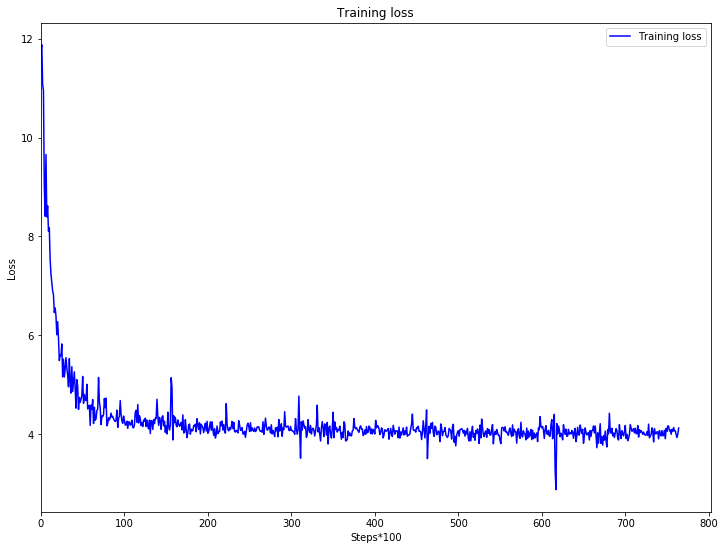

In [37]:
#Plot the model loss
plot_loss("checkpoints/skipgram_losses.csv")

In [39]:
#Initialize the TSNE tool.
#n_components is the dimension number (2-d in our case).
#We use PCA because we have dense data.
#N_iter is set to 4000. Default is 1000 and I didn't see any major difference, but just to be sure, it's higher.
#Method is set to exact because we want the lowest error.
tsne = TSNE(n_components=2, init='pca', n_iter=4000, method="exact")
#Number of word embeddings to consider. Set to 250 so we can see something in the plot.
num_points = 250
print('Fitting embeddings to T-SNE.')
start = timer()
#Get the 250 word embeddings and fit them using tsne.
fit_embeddings = final_embeddings[:num_points, :]
tsne_embeddings = tsne.fit_transform(fit_embeddings)
end = timer()
total = end-start
print("Done in {0} seconds.".format(round(total,3)))

Fitting embeddings to T-SNE.
Done in 3.321 seconds.


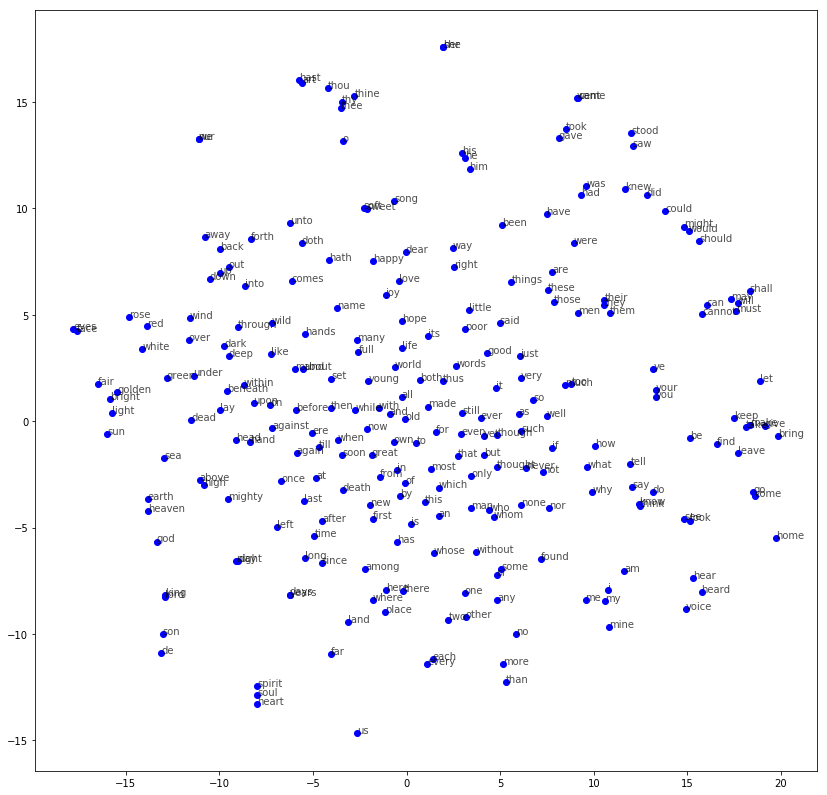

In [40]:
#Simple plot to visualize the fitted embeddings.
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(num_points):
    plt.scatter(*tsne_embeddings[idx, :], color='blue')
    #We call the integer to word mapping dictionary to give the different data points their actual labels.
    #Since the index/row of each embedding is equivalent to the ID number, this gives us the correct labels.
    #tsne_embeddings[idx,0] and tsne_embeddings[idx,1] tells the function which point to annotate with the label.
    #0 and 1 represent the first and second value of the embedding ((x,y) values).
    plt.annotate(int_mapping[idx], (tsne_embeddings[idx, 0], tsne_embeddings[idx, 1]), alpha=0.7)

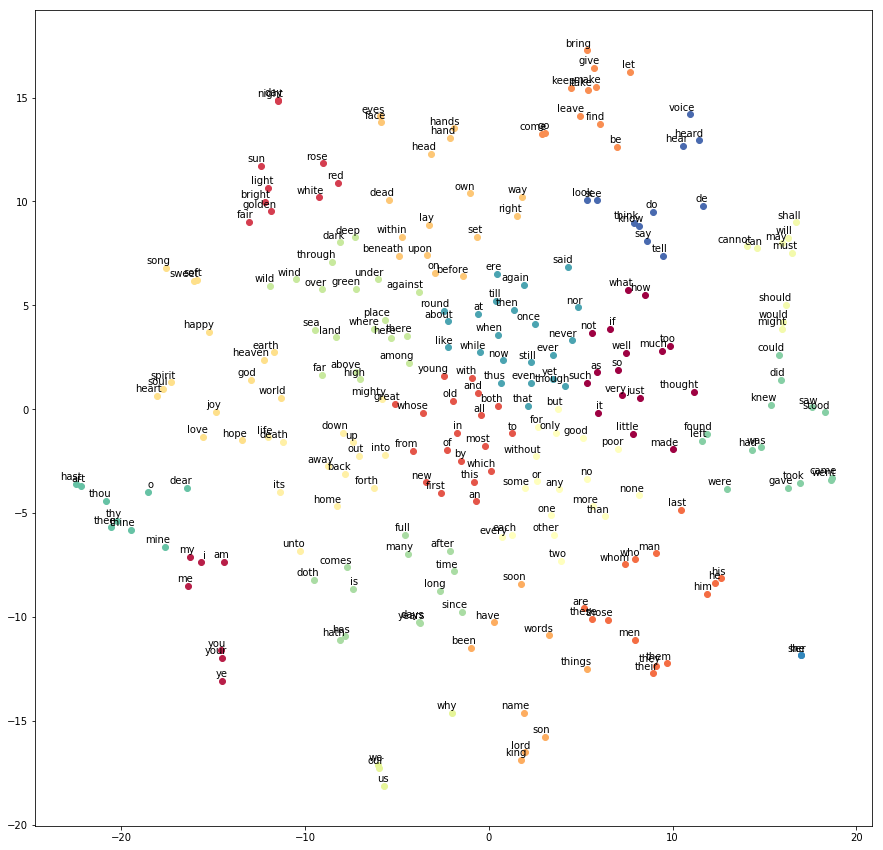

In [19]:
#Plot the same embeddings as above, only this time we can see their assigned clusters.
#Cluster members give us an idea as to which words are connected to each other.
selected_words = [int_mapping[i] for i in range(num_points)]
plot_clusters(tsne_embeddings, selected_words)

<a id='section6'></a>
### 6. Tensorboard visualization.
[(back to top)](#section0)<br>
<br>
The developers of Tensorflow also provide a visualization tool called Tensorboard which will be used to give us an even better look at the embeddings and word relationships.
The code here follows two different sources:
- https://www.tensorflow.org/tensorboard/get_started
- https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_learned_embeddings

There are two approaches to visualizing the embeddings:
1. Load tensorboard in this notebook.
2. Use the embedding projector (http://projector.tensorflow.org/)

Tensorboard can be used locally in the notebook while the above link allows one to navigate the embeddings in a browser. 
All you need for the web page version are vector and metadata files.
The local tensorboard needs model checkpoint files. Luckily, we saved these during training and can have a look at them now.<br>
We start with the local tensorboard.

Content of this section:
- Get additional metadata
- Write files necessary for Embedding Projector
- Load and run local Tensorboard

First, we will get the data necessary to use the embedding projector.<br>
The embedding projector requires tab-separated files:
- vectors: contains the embedding vectors (if using the online projector).
- metadata: contains the words and any other information we might want for a word. I included word count.
    


In [26]:
#Get the word counts one last time.
counts = Counter(words)
#Get the sorted word counts. We want the key order to match the frequency sorted vocabulary.
meta_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

32669


In [29]:
#Write the vectors and metadata to a tsv file
with open("checkpoints/meta.tsv", "w", encoding="utf8") as out_m, open("checkpoints/vecs.tsv", "w", encoding="utf8") as out_v:
    out_m.write("label\tcount\n")
    for num, word in enumerate(vocab):
        vec = final_embeddings[num].numpy()
        word_count = meta_counts[word]
        out_m.write(word + "\t" + str(word_count) + "\n")
        out_v.write('\t'.join([str(x) for x in vec]) + "\n")

With these files saved, we can continue!

In [26]:
#Load tensorboard
%load_ext tensorboard

Ideally, executing the next cell will bring up the projector with the latest checkpoint file loaded.<br>
However, I found that it often said that it was unable to connect. Should that happen, here is a way to get it to load in the notebook (apologies if this is all old news, but I thought it would be best to include it):
1. Open up a python terminal (I use anaconda prompt with 3.7).
2. Cd to the project directory or that directory which contains the checkpoints folder.
3. type "tensorboard --logdir checkpoints" in the terminal.
4. A message along the lines of: "Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all TensorBoard 2.0.2 at http://localhost:6006/ (Press CTRL+C to quit)" should appear. Localhost might vary.
5. Now, execute the following cell. At first, no dashboard will be active. However, a click on the reload at the top right will bring up the projector with the embedding tensors loaded. It is also possible to load other tensors such as the optimizer values. These are not subject to analysis though. It is also possible to copy-paste the localhost link into a browser and look at the embeddings that way.
6. Load the metadata by clicking on "load" in the "Data" section on the left. Select the meta.tsv file (checkpoints/meta.tsv). It will compute PCA again, only this time all points will have their labels and counts!
7. Now, we can click on any point in the space to see which label/count is has and what its nearest neighbors are.

In the top right, we can isolate the point and its nearest neighbors ("isolate x points"), clear the current selection or revert the shown space back to its original form ("show all data").
Additionally, it is possible to search the space by label (i.e. just a regular alphabetic search) or count (i.e. to see words with specific counts).<br>
Once a point is selected, its nearest neighbors will be highlighted in the space. This way, we can see which words seem to have a more refined connection to the selected point. The amount of neighbors can be scaled up or down in the neighbors line (default is 100). Finally, one can navigate from point to point by selecting new and interesting words from the list of nearest words in the bottom right, or just clicking on a new point in the space.<br>
The online embedding projector is used in much the same way. The only difference is that you must first upload the previously created checkpoints/vecs.tsv file in order to create the embedding space. Then add metadata and voilà, good to go!

A more in-depth discussion of the embedding space is provided in the PDF.

In [31]:
#Point tensorboard to the checkpoints folder as the log directory. It will find the latest .ckpt file and initialize it.
%tensorboard --logdir checkpoints

Reusing TensorBoard on port 6006 (pid 13164), started 2 days, 3:17:34 ago. (Use '!kill 13164' to kill it.)

<a id='references'></a>

### References
[back to top](#section0)

[1] Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean. Efficient Estimation of Word Representations in Vector Space. https://arxiv.org/abs/1301.3781. 2013.

[2] Allison Parrish. A Gutenberg Poetry Corpus. https://github.com/aparrish/gutenberg-poetry-corpus. 2018.

[3] Thushan Ganegedara. Natural Language Processing with TensorFlow: Teach language to machines using Python's deep learning library. Packt Publishing Ltd. 2018.

[4] Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo,
Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,
Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow,
Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,
Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,
Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,
Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,
Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,
Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,
Yuan Yu, and Xiaoqiang Zheng.
TensorFlow: Large-scale machine learning on heterogeneous systems, 2015. Software available from tensorflow.org.

[5] Keras Team. Keras: The Python Deep Learning library. https://keras.io/.

[6] Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, Jeffrey Dean. Distributed Representations of Words and Phrases and their Compositionality. https://arxiv.org/abs/1310.4546. 2013.

[7] Scikit-learn Team. scikit-learn: Machine Learning in Python. https://scikit-learn.org/stable/index.html.

[back to top](#section0)